# <a name="toc">Contents</a>


[**1. Preliminaries**](#p1)

[**2. Generate the data**](#p2)
* [2.1 Set the underlying social structure](#p21)
* [2.2 How many pics each node takes at each time step](#p22)
* [2.3 How many people are in each of those pics](#p23)
* [2.4 How are these people chosen](#p24)
* [2.5 Construct the elementary tag matrix](#p25)

[**3. Generate simple graphs**](#p3)
* [3.1 Construct simple weights](#p31)
* [3.2 Create one graph](#p32)
* [3.3 Generate all graphs](#p33)

[**4. Model a social shift**](#p4)
* [4.1 Construct tags after the shift](#p41)

[**5. Time dependent weights**](#p5)
* [5.1 Model description](#p51)
* [5.2 Model illustration](#p52)
* [5.3 Generate strength matrices](#p53)
* [5.4 Construct the graphs and analyze them](#p54)

# <a name="p1a">Introduction</a> [<font size="2">[back]</font>](#toc)

Here we will attempt to develop a dynamical social network model with the aim of capturing potential social shifts from the Instagram data of a user. More specifically, based on the tag information from Instagram pictures, we want to be able to generate a graph centered around some user, and design features that will be predictive of social shifts in his / her life. 

The main idea is to generate a weighted graph with edges that are intrinsically time-dependent, in such a way to easily capture that the tags made at some later time are more relevant than the tags made at some earlier time, which is what we do in Sections 4 and 5. An important part of examining this model will be to generate a realistic social network with a nontrivial underlying social structure that we can easily change, which we do in Sections 1 to 3.

# <a name="p1">1. Preliminaries</a> [<font size="2">[back]</font>](#toc)

We'll use *networkX* package for generating, drawing and analyzing graphs, and *ipywidgets* for interactive widgets.

In [1]:
%pylab inline
import networkx as nx
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from ipywidgets import widgets
from IPython.display import display

/Volumes/Scratch/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


# <a name="p2">2. Generate the data</a> [<font size="2">[back]</font>](#toc)

Number of nodes and number of time steps (e.g. days) over which the nodes will generate edges (i.e. tag each other):

In [3]:
nNodes = 18
nTime = 100

## <a name="p21">2.1 Set the underlying social structure</a> [<font size="2">[back]</font>](#toc)

We'll set up a simple social structure via a scalar function *gCL*, which, for every node, sets its value of "cliqueness" (see below for explanation):

In [4]:
gCLBefore = np.array([0.9]*6 + [0.5]*6 + [0.1]*6)

Plot it:

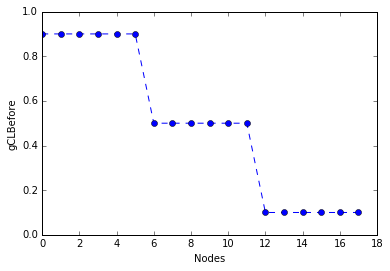

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(gCLBefore, linestyle = 'dashed', marker = 'o')
ax.set_xlabel('Nodes')
ax.set_ylabel('gCLBefore')
plt.ylim([0, 1]);

This *gCL* function will be used to generate probability distributions (later) according to which a particular node chooses other nodes to tag. The idea is that the larger the absolute difference in the *gCL* values between two nodes is, the less likely it is they get tagged in the same picture. For example, if node 2 takes a photo, it is likely that nodes 0-5 will be in it, as they share the same *gCL* values, and much less likely that one of the nodes 12-17 are in it. 

Hence, we have 3 cliques, within which the nodes are closely connected, and they are less well connected with the other cliques. We will then easily generate a social shift by simply changing the *gCL* value for particular nodes (that's why this one here is called *gCLBefore*), and see how the graph evolves in time after that change. Of course, this is a very simplistic model, and for a more complex social network model we would need (at least) the *gCL* function to be an *n*-dimensional vector, but this will do for a simple demonstration.

A particular example I had in mind was in fact myself while I lived in New York, and my subsequent move to Oxford. The plot above corresponds to my time in New York: I'm node 0, nodes 1-5 are my New York friends (with whom I'm more likely to be in photos), nodes 6-11 are my friends in Zagreb (where I would go couple of times a year, and hence will appear in photos with occasionally), and 12-17 are people in Oxford (whom I don't really now at this time). My move in Oxford can then be simply modeled by changing the *gCL* value of node 0 from 0.9 to 0.1, as now I will appear more in photos with the Oxford people, much less with people from New York, and more or less with the same probability with the people in Zagreb, as I still travel there with same frequency. 

Based on this, we will generate a simple social network model, focus on node 0 and try to see how to capture this social shift analytically.

## <a name="p22">2.2 How many pics each node takes at each time step</a> [<font size="2">[back]</font>](#toc)

At every time step, we'll go over all the nodes and decide if each node takes a photo or not, and if so, how many photos does it take. This can be modeled by independent statistical distributions peaked at zero (i.e. so that they most often take no pictures), e.g. an exponential distribution with the scale parameter chosen so that things look okay-ish: (Poisson is not peaked enough around zero)

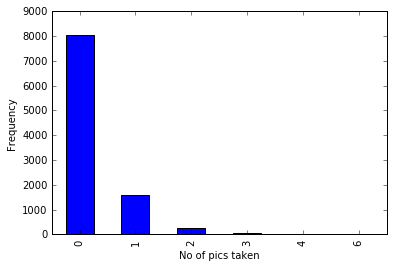

In [6]:
scaleParam = 0.6
s = np.random.exponential(scaleParam, 10000).astype(int)
fig = Series(s).value_counts().sort_index().plot(kind = 'bar')
fig.set_xlabel('No of pics taken')
fig.set_ylabel('Frequency');

So in our case, we would have the following photo distribution at some time step:

In [7]:
np.random.exponential(scaleParam, nNodes).astype(int)

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We do this for every time step and store it in an *nTime x nNodes* matrix:

In [10]:
def generatePicMatrix():
    return np.random.exponential(scaleParam, nTime * nNodes).astype(int).reshape((nTime, nNodes))

## <a name="p23">2.3 How many people are in each of those pics</a> [<font size="2">[back]</font>](#toc)

For each photo in the *picMatrix*, we need to decide how many people will be tagged in it. For that we could use the Poisson distribution with $\lambda = 1$, and add + 1 to it, to remove zeros (and hence discard selfies, for now). This choice gives most pics with 1 and 2 other people tagged:

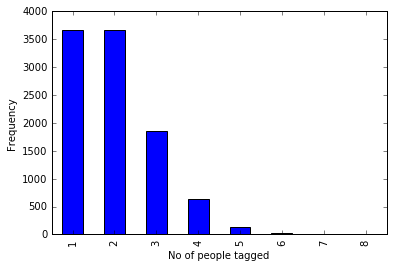

In [11]:
PoisLambda = 1
s = np.random.poisson(PoisLambda, 10000) + 1
fig = Series(s).value_counts().sort_index().plot(kind = 'bar')
fig.set_xlabel('No of people tagged')
fig.set_ylabel('Frequency');

(We should also make sure that the number of people tagged is never larger than the total number of nodes.)

## <a name="p24">2.4 How are these people chosen</a> [<font size="2">[back]</font>](#toc)

We will go one time step at a time, and at each time step we look at which nodes are taking pictures. For that particular node *u* taking the picture, we need to define a probability distribution that some other node *v* will be tagged in the picture with him. For that we will use the *gCL* function and the idea that the larger the absolute difference in the *gCL* values between two nodes is, the less likely it is they get tagged together. We'll simply choose $p(v;u) \propto 1 - |g_{CL}(u) - g_{CL}(v)|$, with appropriate normalizations:

In [12]:
def prob(v, u, gCL):
    norm = sum(1 - abs(gCL - gCL[u])) - 1
    p = (1 - abs(gCL[u] - gCL[v])) / norm
    return p

For usage later, we need to make sure that our probability function gives $p(u;u)=0$:

In [13]:
def probStrict(v, u, gCL):
    if u == v: p = 0
    else: p = prob(v, u, gCL)
    return p

To see how these distributions look like, take one representative node from each clique:

In [14]:
u1 = 1; u2 = 8; u3 = 14;

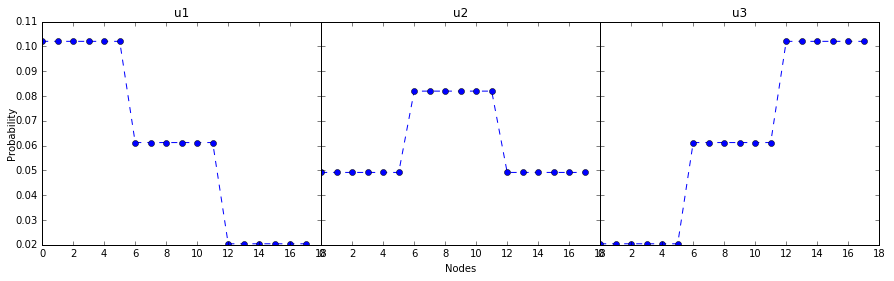

In [15]:
plt.rc('figure', figsize=(15, 4))
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True)
axes[0].plot(prob(np.arange(nNodes), u1, gCLBefore), linestyle = 'dashed', marker = 'o')
axes[1].plot(prob(np.arange(nNodes), u2, gCLBefore), linestyle = 'dashed', marker = 'o')
axes[2].plot(prob(np.arange(nNodes), u3, gCLBefore), linestyle = 'dashed', marker = 'o')
axes[0].set_title('u1')
axes[1].set_title('u2')
axes[2].set_title('u3')
fig.add_subplot(111, frameon = False) # Trick for one shared x-axis label (and next line as well)
plt.tick_params(labelcolor = 'none', top = 'off', bottom = 'off', left = 'off', right = 'off')
plt.xlabel("Nodes")
plt.ylabel("Probability")
plt.subplots_adjust(wspace=0, hspace=0)

Check that they're properly normalized:

In [16]:
[sum(prob(np.arange(nNodes), u1, gCLBefore)) - prob(u1, u1, gCLBefore),
 sum(prob(np.arange(nNodes), u2, gCLBefore)) - prob(u2, u2, gCLBefore),
 sum(prob(np.arange(nNodes), u3, gCLBefore)) - prob(u3, u3, gCLBefore)]

[1.0, 1.0, 1.0000000000000002]

As usual, to get random numbers according to these distributions, we need to feed a random number [0,1) to its inverse CDF, which is trivial for discrete distributions:

In [17]:
def invCDF(x, u, gCL):
    rl = [probStrict(0, u, gCL)]
    for n in range(1, nNodes): rl = rl + [rl[n - 1] + probStrict(n, u, gCL)] # Save all the steps of CDF in a list
    n = 0; myN = 0; cont = True;
    while cont == True: # Scan the list until you find the step that's larger than x
        if x <= rl[n]: myN = n; cont = False;
        else: n = n + 1  
    return myN

Check we got it right (note the *sampleU* node is missing, as it should be):

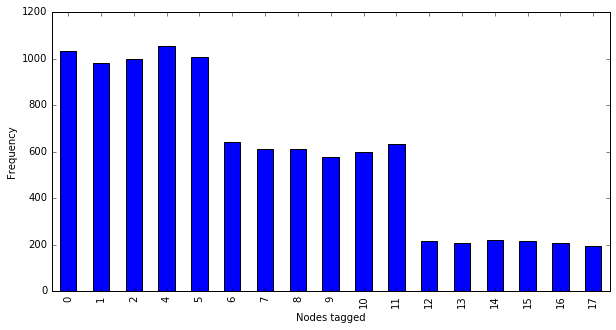

In [18]:
sampleSize = 10000
sampleU = 3
sample = []
for i in range(sampleSize):
    sample = sample + [invCDF(np.random.rand(), sampleU, gCLBefore)]
plt.rc('figure', figsize=(10, 5))
fig = Series(sample).value_counts().sort_index().plot(kind = 'bar')
fig.set_xlabel('Nodes tagged')
fig.set_ylabel('Frequency');

## <a name="p25">2.5 Construct the elementary tag matrix</a> [<font size="2">[back]</font>](#toc)

Based on all this we can now generate the tag matrix, which will really be a list of length *nTime*, with each element being itself a list of tuples indicating the tags made at that time step. We call this elementary, as it comprises the elementary social network data, based on which we can start constructing graphs, choosing how to compute weights, etc.

* We go over every time step *t*, and at each time step, look at the corresponding line in the *picMatrix* (which is *gCL*-independent)
* Then we go over every node *u*, and for each node we go over the number of pics *p* (if any) it is taking at this time step.
* For each of these pics, we choose the number of people tagged, *noTags*, according to the Poisson distribution.
* For each of the tags in *noTags*, we then choose the nodes tagged according to *invCDF* (the only thing *gCL*-dependent here), making sure there are no duplicates. 

In [19]:
def generateTagMatrix(gCL, picMatrix):
    tagMatrix = []
    for t in range(nTime):
        picList = picMatrix[t]
        tagList = []
        for u in range(nNodes):
            for p in range(picList[u]):
                noTags = np.random.poisson(PoisLambda) + 1
                vList = []
                for tag in range(noTags):
                    isVIn = True
                    while isVIn == True:
                        v = invCDF(np.random.rand(), u, gCL)
                        if (v in vList) == False:
                            isVIn = False
                            vList = vList + [v]
                for v in vList:
                    tagList = tagList + [(v, u)]
        tagMatrix = tagMatrix + [tagList]
    return tagMatrix

Then all the tags (edges) made at some time step *t* are given by *tagMatrix[t]*:

In [20]:
picMatrixBefore = generatePicMatrix()
tagMatrixBefore = generateTagMatrix(gCLBefore, picMatrixBefore)
print tagMatrixBefore[58]

[(17, 6), (16, 6)]


# <a name="p3">3. Generate simple graphs</a> [<font size="2">[back]</font>](#toc)

Previously generated tag matrix is now sufficient to start creating graphs. In this section, let's just create simple weighted graphs, where the weights of edges are equal to the number of tags between the nodes they connect, just to make sure our simple model so far makes some sense.

## <a name="p31">3.1 Construct simple weights</a> [<font size="2">[back]</font>](#toc)

First we need to define the weight tensor that we'll use to generate the dynamical graphs. We call it a tensor below, as it will be a list of matrices, with each of the matrices being a weight (adjacency) matrix at some time step, which we can directly feed into *networkX*'s graph generating routines.

In [21]:
def generateWeightTensor(tagMatrix):
    weightTensor = [array([0] * nNodes * nNodes).reshape((nNodes, nNodes))]
    for t in range(nTime):
        for pair in tagMatrix[t]:
            orderedPair = pair
            if pair[0] > pair[1]: # We choose the upper right weight matrix
                orderedPair = (pair[1], pair[0])
            weightTensor[t][orderedPair] = weightTensor[t][orderedPair] + 1
        weightTensor = weightTensor + [np.copy(weightTensor[t])] # Needs to be copied explicitly
    return weightTensor

The weighted adjacency (weight) matrix at some time *t* is then simply given by *weightTensor[t]*:

In [23]:
weightTensorBefore = generateWeightTensor(tagMatrixBefore)
weightTensorBefore[22]

array([[0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0],
       [0, 0, 4, 2, 2, 2, 1, 2, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 2, 3, 0, 1, 3, 2, 2, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 3, 2, 2, 1, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 2, 5, 3, 4, 3, 4, 1, 2, 0, 3, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 1, 1, 0, 1, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 2, 0, 1, 1, 3, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 2, 2, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 1, 4, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 6, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## <a name="p32">3.2 Create one graph</a> [<font size="2">[back]</font>](#toc)

We can now generate graphs with these weight matrices, but we first need to convert them to explicit *numpy* matrices (*networkX*'s requirement) and name the data type as 'weight':

In [24]:
G = nx.from_numpy_matrix(np.matrix(weightTensorBefore[1], dtype = [('weight', int)]))
G.edges(data = True)

[(0, 8, {'weight': 1}),
 (1, 2, {'weight': 1}),
 (1, 3, {'weight': 1}),
 (1, 4, {'weight': 1}),
 (1, 6, {'weight': 1}),
 (3, 4, {'weight': 1}),
 (3, 5, {'weight': 1}),
 (4, 15, {'weight': 1}),
 (4, 14, {'weight': 1}),
 (4, 7, {'weight': 1}),
 (5, 14, {'weight': 1}),
 (6, 8, {'weight': 1}),
 (6, 10, {'weight': 1}),
 (6, 12, {'weight': 1}),
 (6, 9, {'weight': 1}),
 (8, 15, {'weight': 1}),
 (9, 13, {'weight': 1}),
 (10, 12, {'weight': 1}),
 (12, 16, {'weight': 1}),
 (12, 13, {'weight': 1}),
 (14, 17, {'weight': 1})]

We can now plot these graphs, coloring the nodes according to their value of *gCL* (so nodes belonging to the same clique have the same color) and making the thickness of the edges proportional to the weight:

In [25]:
def generateGraph(t, weightTensor, gCL):
    G = nx.from_numpy_matrix(np.matrix(weightTensor[t], dtype = [('weight', int)]))
    fac = 15. / float(np.amax(weightTensor[nTime])) # So the edge widths are nicely scaled
    edgeWidth = [fac * d['weight'] for (u, v, d) in G.edges(data = True)]
    plt.rc('figure', figsize=(10, 10))
    plt.axis('off')
    plt.title("Time = " + str(t) + " / " + str(nTime - 1), fontdict = {"fontsize": 20})
    pos = nx.circular_layout(G) # Positioning of the nodes; the alternative is nx.spring_layout(G), etc.
    nx.draw_networkx_nodes(G, pos, node_size=1000, cmap = plt.get_cmap('brg'), node_color = gCL, alpha = 0.8)
    nx.draw_networkx_labels(G, pos, font_size = 15, font_family = 'sans-serif')
    nx.draw_networkx_edges(G, pos, width = edgeWidth, alpha = 0.7);

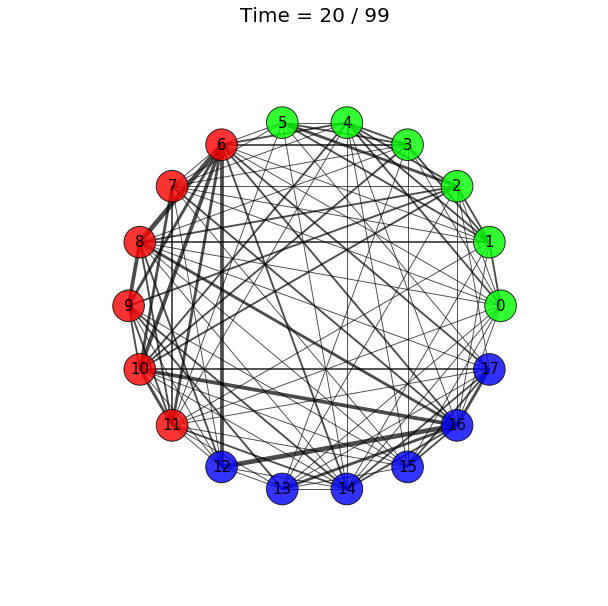

In [26]:
generateGraph(20, weightTensorBefore, gCLBefore)

## <a name="p33">3.3 Generate all graphs</a> [<font size="2">[back]</font>](#toc)

To inspect the dynamical evolution of this network, we'll use the interactive sliders from *ipywidgets*. Since the generation of each of the graphs takes a little bit of time, we'll avoid computing them on the fly (i.e. as we move the slider), and precompute them:

In [36]:
def generateAllGraphs(weightTensor, gCL):
    figs = []
    totalTime = len(weightTensor) - 1
    for t in range(totalTime):
        fig = plt.figure()
        generateGraph(t, weightTensor, gCL)
        figs = figs + [fig]
        plt.close() # So figure is not being displayed (we're using pylab inline)
    return figs

For *ipywidgets* we'll need a function that explicitly displays these:

In [37]:
def show_fig(t, figs):
    display(figs[t])

Generate the graphs and display them:

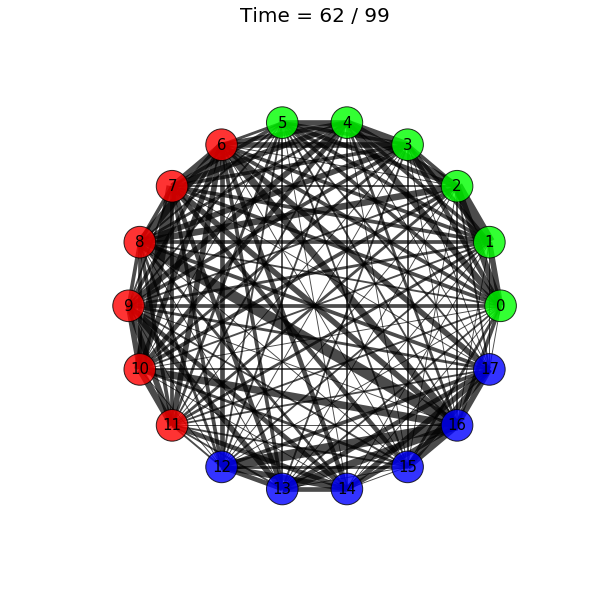

In [38]:
figsBefore = generateAllGraphs(weightTensorBefore, gCLBefore)
widgets.interact(show_fig, 
                 t = widgets.IntSlider(min = 0, max = nTime - 1, step = 1, value = 0), 
                 figs = widgets.fixed(figsBefore));

Here we see how the cliques are best connected among themselves, and how the first (green) and the third (blue) cliques have relatively little connection between each other, but their connection to the second (red) clique is more noticeable, as we would expect from the form of the *gCL* function we used.

# <a name="p4">4. Model a social shift</a> [<font size="2">[back]</font>](#toc)

## <a name="p41">4.1 Construct tags after the shift</a> [<font size="2">[back]</font>](#toc)

As announced earlier, the simple social shift we'll immitate here is the migration of node 0 from the first clique to the third one, which can be easily done by modifying its value of *gCL*:

In [39]:
gCLAfter = np.array([0.1] + [0.9]*5 + [0.5]*6 + [0.1]*6)

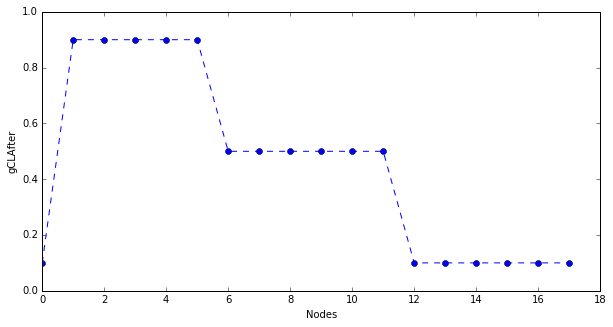

In [40]:
plt.rc('figure', figsize = (10, 5))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(gCLAfter, linestyle = 'dashed', marker = 'o')
ax.set_xlabel('Nodes')
ax.set_ylabel('gCLAfter')
plt.ylim([0, 1]);

We'll now generate a new *picMatrix*, and, using this new *gCL*, also a new *tagMatrix* and *weightTensor*, which will then be used to generate new graphs:

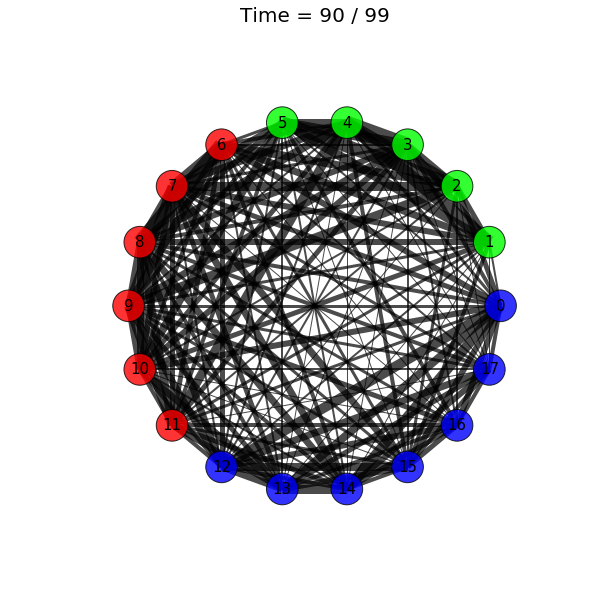

In [41]:
picMatrixAfter = generatePicMatrix()
tagMatrixAfter = generateTagMatrix(gCLAfter, picMatrixAfter)
weightTensorAfter = generateWeightTensor(tagMatrixAfter)
figsAfter = generateAllGraphs(weightTensorAfter, gCLAfter)
widgets.interact(show_fig, 
                 t = widgets.IntSlider(min = 0, max = nTime - 1, step = 1, value = 0), 
                 figs = widgets.fixed(figsAfter));

Here we see (perhaps not super clearly) how node 0 now belongs to the third clique (at least more than to the first one).

The graphs above show only the tags after the shift, and if we included all the tags (before and after the shift), it would be an even bigger mess and much harder to see the shift. However, in the next section, we'll try to develop a weighted graph that can capture this better, and for this we will need one large tag matrix, that will include both the tags before and after the shift:

In [46]:
tagMatrixFull = tagMatrixBefore + tagMatrixAfter

# <a name="p5">5. Time dependent weights</a> [<font size="2">[back]</font>](#toc)

## <a name="p51">5.1 Model description</a> [<font size="2">[back]</font>](#toc)

To capture the dynamics described earlier, it seems that the edges need to be intrinsically time dependent. That is, the tags should have some sort of "expiration date": if you're tagged in a photo with someone from 5 years ago, but you haven't spoken to him since, that tag somehow needs to be much less important than a tag in a photo from last week's shindig with your best friends. 

If we define the weight of an edge *w* as *w = 1 / s*, where *s* is the "strength" of the connection between two nodes, then a simple way to encode the previous idea is to add to strength *s*, for each new tag that happens at some time *t_tag*, an exponentially decaying function of time *exp(- r (t-t_tag))*, where *r* is some sort of "forgetfulness" rate (that could be machine learned later). (Note what we called "weights" earlier are really strengths.)

In this way, initially, if there are no edges between two nodes, *s = 0*, and *w = infty*, as it should be. Then, say you get tagged in one photo with this node: the weight immediately becomes equal to 1, but then starts growing in time exponentially. The more tags there are, the stronger the connection between the nodes (and hence smaller the weight), but each of these connections "decay" and eventually the nodes "forget" about each other, if no new tags are being made.

With such weights, even if there are no edge nor node modifications in the graph, the weights would still change in time on their own, and hence things like centrality of a given node would change as well. This kinda makes sense, because if time passes and you're not being tagged in photos (and you have been before), then something is happening: maybe you're learning for an exam and not going out, or maybe you're depressed (these two presumably occur on different time scales). 

## <a name="p52">5.2 Model illustration</a> [<font size="2">[back]</font>](#toc)

For example, take two nodes: the "A" node is one from the clique before (with which you get tagged in the beginning) and node "B" is from the clique you join later. Let's take the forgetfullness rate to be the same for all these, and equal to 1 / 100 (i.e. you "forget" tags after time on the order of 100), having in mind the time scales from the previous sections.

In [64]:
rSample = 1. / 100.
tTagSampleA = [5, 10, 30, 60]
tTagSampleB = [110, 150, 170, 190]

The total time is 200, and at each time step we'll compute the strength of the connection between you and the two nodes, and save them into two lists:

In [53]:
strengthA = []
strengthB = []
for t in range(2 * nTime):
    locStrengthA = 0
    locStrengthB = 0
    for tTag in tTagSampleA:
        if t >= tTag: locStrengthA = locStrengthA + np.exp(- rSample * (t - tTag))
    for tTag in tTagSampleB:
        if t >= tTag: locStrengthB = locStrengthB + np.exp(- rSample * (t - tTag))
    strengthA = strengthA + [locStrengthA]
    strengthB = strengthB + [locStrengthB]

Let's plot the two as a function of time:

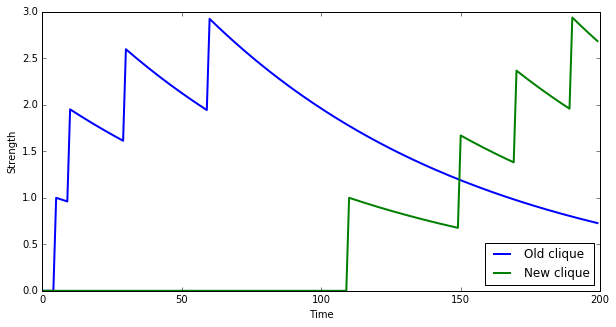

In [63]:
plt.rc('figure', figsize = (10, 5))
plt.plot(strengthA, label = 'Old clique', linewidth = 2.0)
plt.plot(strengthB, label = 'New clique', linewidth = 2.0)
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Strength');

We see how, after time = 200, the strength of the connection with the new clique is much higher than with the old one.

## <a name="p53">5.3 Generate strength matrices</a> [<font size="2">[back]</font>](#toc)

Here we'll generate the strength matrices, which will be used to draw the graphs and analyze them. For some of the analysis we will need weights (i.e. 1 / strengths), but for drawing and some simpler analysis, strengths are sufficient.

We start by generating *tagAdjTensor*, a list of length *nTime* of (essentially adjacency) *nNode x nNode* matrices, where each matrix encodes the tags made at that time by a 1 in the appropriate place and 0 otherwise. This is done so that we can calculate the weights at any time efficiently.

In [79]:
tagAdjTensor = array([0] * nNodes * nNodes * 2 * nTime).reshape((2 * nTime, nNodes, nNodes))
for t in range(2 * nTime):
    for pair in tagMatrixFull[t]:
        orderedPair = pair
        if pair[0] > pair[1]:
            orderedPair = (pair[1], pair[0])
        tagAdjTensor[t][orderedPair] = 1

We'll choose a rather high value for the forgetfullness rate, to make graphs easier to read.

In [220]:
rForget = 1. / 50.

Now we generate the *strengthTensor* (same form as the previous *weightTensor*), where each element is a matrix of strengths at a particular time:

In [221]:
strengthTensor = array([0.] * nNodes * nNodes * 2 * nTime).reshape((2 * nTime, nNodes, nNodes))
for t in range(2 * nTime):
    allStrengths = np.exp(- rForget * (t - (np.arange(t) + 1))) # Generate all possible strengths at a given time
    for i in range(nNodes):
        for j in range(i + 1, nNodes):
            strengthTensor[t, i, j] = np.dot(tagAdjTensor[0 : t, i, j], allStrengths) 
            # Dot it with 1's and 0's from tagAdjTensor to select the right strengths

## <a name="p54">5.4 Construct the graphs and analyze them</a> [<font size="2">[back]</font>](#toc)

To generate the graphs, we can use the same function *generateGraph* as before (*gCLBefore* used in the third argument is just for coloring of the nodes):

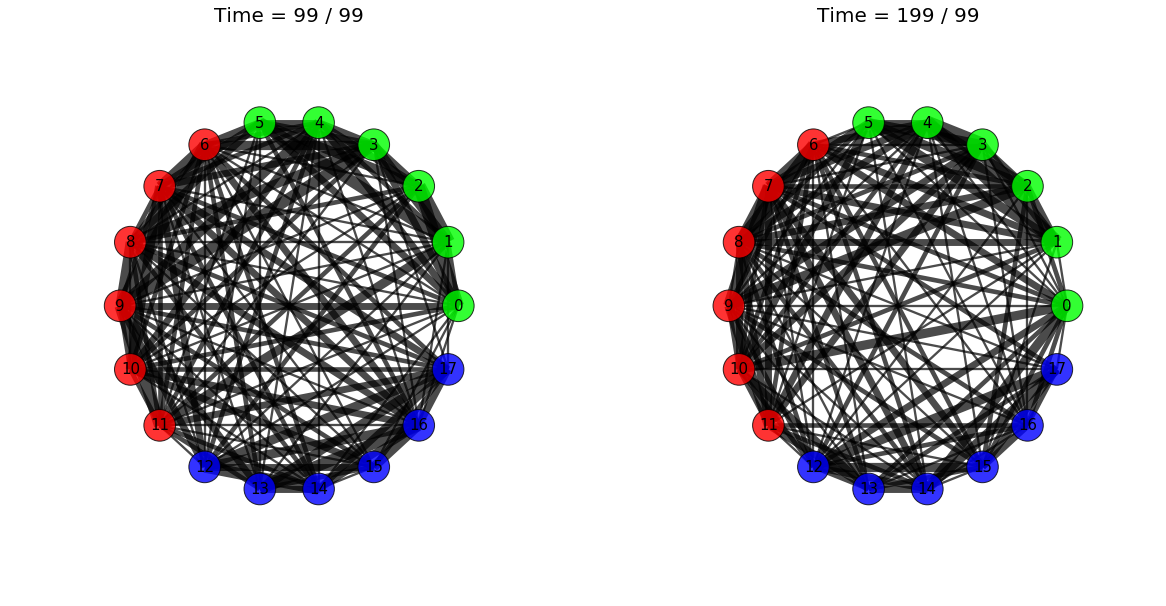

In [222]:
plt.rc('figure', figsize = (20, 10))
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1 = generateGraph(99, strengthTensor, gCLBefore)
ax2 = fig.add_subplot(1, 2, 2)
ax2 = generateGraph(199, strengthTensor, gCLBefore)

Although it may be hard to see, but it seems that, in the left graph, the first node is more connected to the green clique, and in the right graph it seems to be more connected to the blue one. To be more quantitative, we could plot the average strength between node 0 and the three cliques (i.e. averaged over the number of nodes in the clique), as a function of time:

In [223]:
avStrength = []
for t in range(2 * nTime):
    node0Strengths = strengthTensor[t, 0, :].reshape(3,6) # To separate it into 3 cliques
    meansByClique = np.mean(node0Strengths, axis = 1) * array([6. / 5., 1, 1]) # Calculate the mean for each clique
    avStrength = avStrength + [list(meansByClique)]

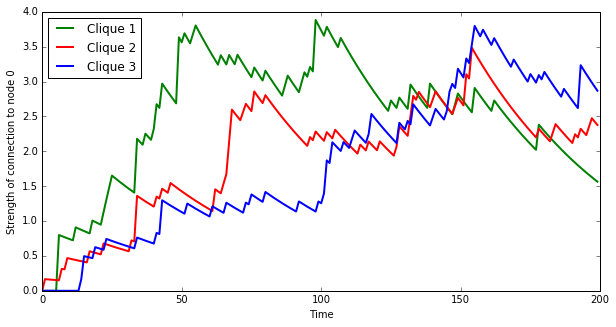

In [224]:
plt.rc('figure', figsize = (10, 5))
plt.plot(list(array(avStrength)[:,0]), label = 'Clique 1', linewidth = 2.0, color = 'g')
plt.plot(list(array(avStrength)[:,1]), label = 'Clique 2', linewidth = 2.0,color = 'r')
plt.plot(list(array(avStrength)[:,2]), label = 'Clique 3', linewidth = 2.0,color = 'b')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Strength of connection to node 0');

We can now clearly see the switching of node 0 from clique 1 to clique 3. Of course, this is so clear as here we're using the knowledge that there are 3 underlying cliques, so in the next iteration of this notebook, we'll examine some more standard graph-theoretical observables, such as the clustering coefficient, centralities, transitivity, etc.